In [9]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:reshape2’:

    dcast, melt




In [10]:
#Load in the depmap expression data 
setwd("../data")
depmap.expression = fread("22q1_expression.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1))

In [14]:
#Grab every gene that is on chr9 and test if expression of those genes is also associated with CDKN2B expression
setwd("../data")
refgene = fread("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, 7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, strand, gene) %>%
distinct(gene, .keep_all = TRUE) %>%
filter(chr %in% "chr9") 

genes.on.chr9 = refgene %>% pull(gene) %>%
intersect(names(depmap.expression))

In [5]:
#Load in the SNP genotype matrix and format it
#First, load in the sample names
setwd("../data")
sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(1) %>%
c("snp", .)

#load in the filtered SNPS
setwd("../data")
filtered.snps = read.table("extracted.snps", sep = "\t") 

#Now assemble the big matrix
assembled.matrix = filtered.snps %>%
select(-1, -2, -3, -4, -5, -6, -7, -8, -9) %>%
apply(2, function(x){gsub(":..*", "", x)}) %>%
apply(2, function(x){gsub("0\\|0", "0", x)}) %>%
apply(2, function(x){gsub("0\\|1", "1", x)}) %>%
apply(2, function(x){gsub("1\\|0", "1", x)}) %>%
apply(2, function(x){gsub("1\\|1", "2", x)}) %>%
data.frame() %>%
mutate("snp" = filtered.snps$V3, .before = 1) %>%
rename_all(~sample.names)

In [6]:
#Get a list of samples with the snp and samples without the snp
samples.with.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select_if(~max(.) >= 1) %>%
colnames(.) %>%
.[2:length(.)]

samples.without.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select_if(~min(.) == 0) %>%
colnames(.) %>%
.[2:length(.)]


In [25]:
#Load in the gene-level CN data
setwd("../data")
depmap.cn = fread("22q1_CCLE_gene_cn.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1))

In [27]:
#Extract the CN information for just CDKN2B
cdkn2b.cn = depmap.cn %>%
rename("sample" = 1) %>%
select(sample, CDKN2B)

#assemble a data frame that has the cell line name and the SNP call for our favorite SNP
cdkn2b.snp = assembled.matrix %>% filter(snp %in% "chr9:21986219:C:T") %>%
select(-snp) %>%
t() %>%
data.frame() %>%
rename("snp.call" = 1) %>%
mutate(sample = row.names(.), .before = snp.call)

#merge them both together
merged.cn.snp = inner_join(cdkn2b.cn, cdkn2b.snp, by = "sample")

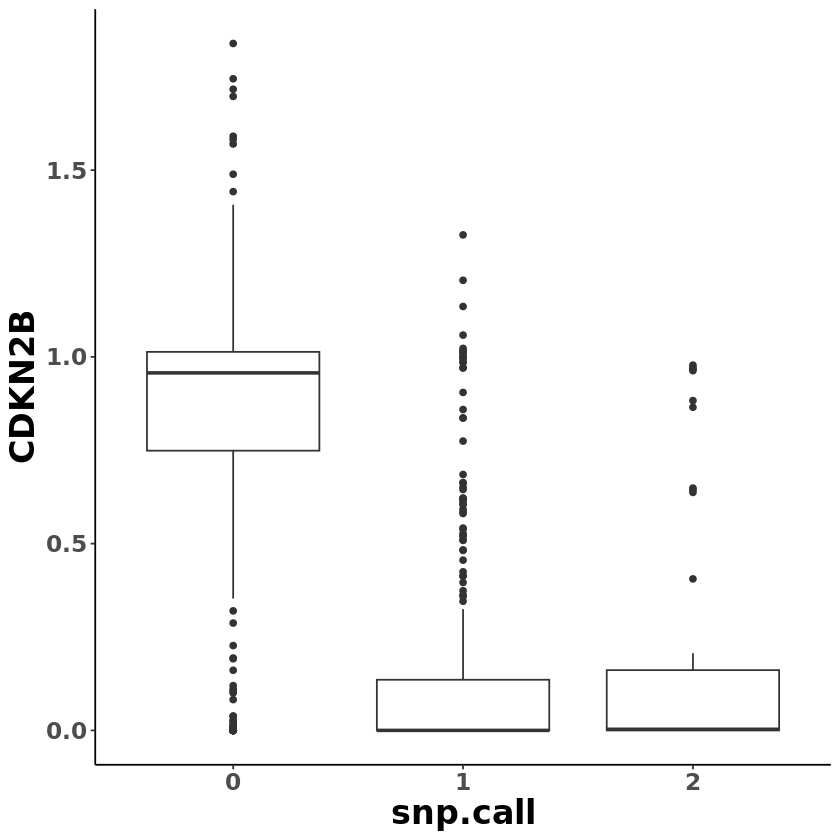

In [29]:
#Now plot the copy number as a function of the SNP call
merged.cn.snp %>%
ggplot() +
geom_boxplot(aes(x = snp.call, y = CDKN2B)) +
theme_bw() +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 20, face = "bold"),
axis.title.y = element_text(color = "black", size = 20, face = "bold")
) +

theme(
axis.text=element_text(size = 14, face = "bold"),
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) 

setwd('../output')
ggsave("supplemental_figure_2.pdf", width = 5, height = 3)

In [30]:
#Write the data to a file
setwd("../data")
write.table(merged.cn.snp, "supplemental_figure_2_merged_cn_snp.txt", sep = "\t", col.names = TRUE, row.names = F, quote = F)